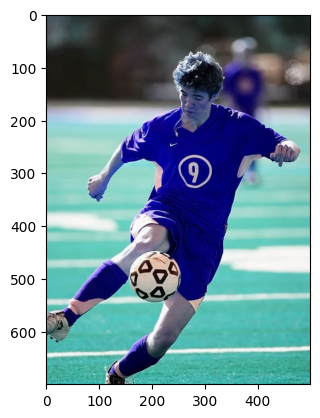

In [1]:
import torch
import numpy as np
from collections import Counter
from ultralytics import YOLO
from easyocr import Reader
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
import matplotlib.pyplot as plt
import cv2
# import keras_ocr
yolo_model = YOLO('./models/best.pt')

model_path = './models/RealESRGAN_x4plus.pth'

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)

upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=0,
    pre_pad=0,
    half=False,  # ✅ Use half precision
    device=torch.device('cuda')  # ✅ Use GPU
)
# Build the pipeline (loads detector and recognizer models)
# pipeline = keras_ocr.pipeline.Pipeline()
reader = Reader(['en'], gpu=True)
video_path = './Assignment Materials/Assignment Materials/15sec_input_720p.mp4'
video_2_path = './Assignment Materials/Assignment Materials/broadcast.mp4'
video_3_path = './Assignment Materials/Assignment Materials/tacticam.mp4'
image_path = './Assignment Materials/manual test/image.png'
image_2_path = './Assignment Materials/manual test/image2.png'
img = cv2.imread(image_path)
img_2 = cv2.imread(image_2_path)

plt.imshow(cv2.imread(image_path))

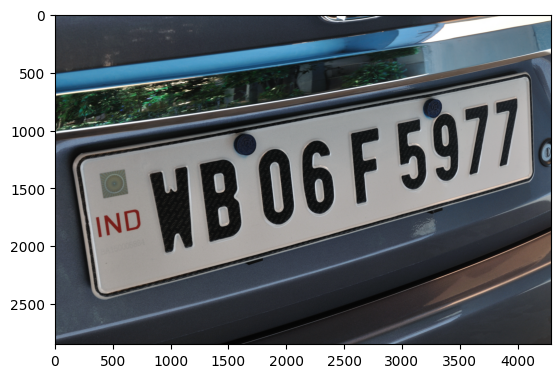

In [ ]:
plt.imshow(cv2.imread(image_2_path))

In [ ]:
# Open video
cap = cv2.VideoCapture(video_path)  # or 0 for webcam

def get_dominant_channel_color(bgr):
    b, g, r = bgr
    max_val = max(b, g, r)
    
    if r == max_val:
        return 'red'
    elif g == max_val:
        return 'green'
    else:
        return 'blue'

while cap.isOpened():
    crops = []
    ret, frame = cap.read()
    if not ret:
        break

    # Run detection
    results = yolo_model(frame)[0]

    # Draw boxes
    for box in results.boxes:
        cls_id = int(box.cls[0])
        if cls_id!=2:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # bounding box
        # Create a crop of the detected object
        crop = frame[y1:y2, x1:x2]
        crops.append(crop)
        conf = box.conf[0]
        
        label = yolo_model.names[cls_id]

        # Draw
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    previous_crops = crops.copy()

    cv2.imshow("YOLO Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

16


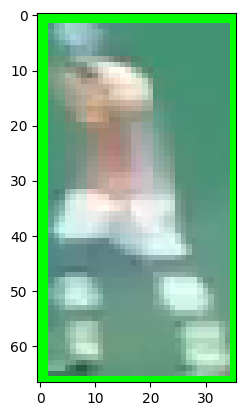

In [4]:
print(len(crops))
crop = crops[1].copy()
plt.imshow(crop)

Detected grayscale text: 9, Confidence: 0.96


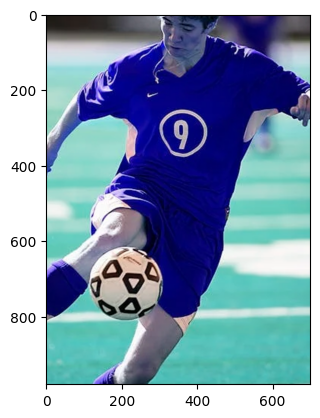

In [ ]:
# Crop the central region of img
h, w, _ = img.shape

# Define central crop region (e.g., middle 50% width, 40% height)
x1 = int(w * 0.2)
x2 = int(w * 0.9)
y1 = int(h * 0.2)
y2 = int(h * 0.9)

# Crop it
center_crop = img[y1:y2, x1:x2]

# Convert the cropped image to RGB for easyocr
center_crop_rgb = cv2.cvtColor(center_crop, cv2.COLOR_BGR2GRAY)

# Upscale by 2×
scale = 2
upscaled_img = cv2.resize(center_crop, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
upscaled_img_2 = cv2.resize(center_crop_rgb, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

plt.imshow(upscaled_img, cmap='gray')

# Read text from the image
result = reader.readtext(upscaled_img)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected text: {text}, Confidence: {confidence:.2f}")

result = reader.readtext(upscaled_img_2)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    if confidence > 0.9:
        print(f"Detected grayscale text: {text}, Confidence: {confidence:.2f}")

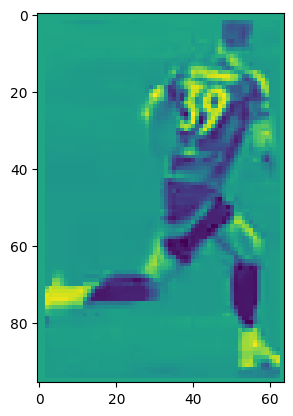

In [132]:
output, _ = upsampler.enhance(crop, outscale=4)

plt.imshow(output)

img = crop.copy()

# Convert to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_img_e = clahe.apply(gray_img)

# Upscale by 2×
# scale = 10
# upscaled_img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
# upscaled_img_2 = cv2.resize(gray_img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
# upscaled_img_3 = cv2.resize(gray_img_e, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

plt.imshow(gray_img)

# Read text from the image
result = reader.readtext(img)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected text: {text}, Confidence: {confidence:.2f}")

result = reader.readtext(gray_img)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected grayscale text: {text}, Confidence: {confidence:.2f}")

result = reader.readtext(gray_img_e)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected grayscale histogram text: {text}, Confidence: {confidence:.2f}")

In [ ]:
output, _ = upsampler.enhance(crop, outscale=4)

plt.imshow(output)

img = crop.copy()

# Convert to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_img_e = clahe.apply(gray_img)

# Upscale by 2×
# scale = 10
# upscaled_img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
# upscaled_img_2 = cv2.resize(gray_img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
# upscaled_img_3 = cv2.resize(gray_img_e, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

plt.imshow(gray_img)

# Read text from the image
result = reader.readtext(img)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected text: {text}, Confidence: {confidence:.2f}")

result = reader.readtext(gray_img)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected grayscale text: {text}, Confidence: {confidence:.2f}")

result = reader.readtext(gray_img_e)
# Print the results
for detection in result:
    text = detection[1]
    confidence = detection[2]
    print(f"Detected grayscale histogram text: {text}, Confidence: {confidence:.2f}")

Final Prototype

In [2]:
def hsv_to_color_name_from_tuple(bgr_tuple):
    # Convert BGR tuple to a 1x1 image for OpenCV color conversion
    bgr_array = np.array([[bgr_tuple]], dtype=np.uint8)
    hsv = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2HSV)[0][0]
    h, s, v = hsv

    if v < 50:
        return 'black'
    elif s < 30 and v > 200:
        return 'white'
    elif s < 40:
        return 'gray'
    elif 0 <= h <= 10 or h >= 160:
        return 'red'
    elif 11 <= h <= 25:
        return 'orange'
    elif 26 <= h <= 34:
        return 'yellow'
    elif 35 <= h <= 85:
        return 'green'
    elif 86 <= h <= 130:
        return 'blue'
    elif 131 <= h <= 159:
        return 'purple'
    else:
        return 'unknown'



In [10]:
# Open video
cap = cv2.VideoCapture(video_path)  # or 0 for webcam

fourcc = cv2.VideoWriter_fourcc(*'H264')

fps = cap.get(cv2.CAP_PROP_FPS)

# max_frames = int(fps * max_duration)
frame_count = 0

# ✅ new: dynamically grab input’s FPS and frame size
fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = 'output_15sec_input_720p.mp4'

out = cv2.VideoWriter(
        output_path,
        fourcc,
        fps,
        (width, height)
    )

frame_count = 0
while cap.isOpened():
    crops = []
    ret, frame = cap.read()
    if not ret:
        break

    # Run detection
    results = yolo_model(frame)[0]
    frame_count += 1
    # if frame_count < 50:
        # continue
    # Draw boxes
    for box in results.boxes:
        cls_id = int(box.cls[0])
        if cls_id!=2:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # bounding box
        # Create a crop of the detected object
        crop = frame[y1:y2, x1:x2]

        # Step 2: Reshape image to a list of pixels
        pixels = crop.reshape(-1, 3)  # shape becomes (num_pixels, 3)

        # Step 3: Convert each pixel to a tuple (hashable for counting)
        pixel_tuples = [tuple(pixel) for pixel in crop.reshape(-1, 3)]
        
        most_common_pixel = Counter(pixel_tuples).most_common(1)[0][0]

        # Get color name
        label = hsv_to_color_name_from_tuple(most_common_pixel)
        # crops.append(crop)
        conf = box.conf[0]

        upscale_method = 1

        if upscale_method == 0:
            crop, _ = upsampler.enhance(crop, outscale=4)

        elif upscale_method == 1:
            # Upscale by 2×
            scale = 10
            crop = cv2.resize(crop, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

        # Convert to grayscale
        # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        # gray_img_e = clahe.apply(gray_img)

        texts = []
        confs = []

        result_2 = reader.readtext(crop)
        # Print the results
        for detection in result_2:
            texts.append(detection[1])
            confs.append(detection[2])

        title = "YOLO Detection"
        if len(confs) != 0:
            id = confs.index(max(confs))
            text = texts[id]
            if text.isdigit():
                label += f" {text}"

        # Draw
        # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'{label}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    previous_crops = crops.copy()

    cv2.imshow(title, frame)
    # Write processed frame to output video
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 1 ball, 16 players, 2 referees, 211.0ms
Speed: 4.8ms preprocess, 211.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 59.6ms
Speed: 5.5ms preprocess, 59.6ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)
